# Bone age prediction of hand radiographs using Neural Networks

In [42]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import time

# import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = (10, 6)
# mpl.rcParams['axes.grid'] = True
# mpl.rcParams['legend.fontsize'] = 'large'

%matplotlib inline
np.random.seed(1)

IMG_SIZE = 224
batch_size = 32

## Retrieve datasets

In [3]:
import os
import zipfile

# Define the data folder location
path = '/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/'
data_dirs = ['Bone Age Training Set', 'Bone Age Validation Set','Bone Age Test Set']
train_dirs = ['boneage-training-dataset', 'dataset_data_file_training-gt-6aaa9791-5bdc-4c6d-9ee9-5a3780a37103']
val_dirs = ['boneage-validation-dataset-1', 'boneage-validation-dataset-2']

# Extract data from zip file
for data_dir in data_dirs:
  if not os.path.exists(data_dir):
  # if not os.path.exists(path + 'data/' + data_dir):
    with zipfile.ZipFile(path + data_dir + '.zip', 'r') as f:
      f.extractall('.')
      # f.extractall(path + 'data')
  if 'Training' in data_dir: # training set has two more zip files
    for train_dir in train_dirs:
      if not os.path.exists(train_dir):
        with zipfile.ZipFile(data_dir + '/' + train_dir + '.zip', 'r') as f:
          f.extractall('.')
      # if not os.path.exists(path + 'data/' + data_dir + '/' + train_dir):
      #   with zipfile.ZipFile(path + 'data/' + data_dir + '/' + train_dir + '.zip', 'r') as f:
      #     f.extract(path + data_dir)
  if 'Validation' in data_dir: # validation set is divided in two more zip files
    for val_dir in val_dirs:
      if not os.path.exists(val_dir):
        with zipfile.ZipFile(data_dir + '/' + val_dir + '.zip', 'r') as f:
          f.extractall('.')
      # if not os.path.exists(path + 'data/' + data_dir + '/' + val_dir):
      #   with zipfile.ZipFile(path + 'data/' + data_dir + '/' + val_dir + '.zip', 'r') as f:
      #     f.extractall(path + 'data/' + data_dir)

In [4]:
# !cp -R /content/boneage-training-dataset /content/boneage-training-masked
# !mkdir /content/boneage_training_masked
# !rm -r "/content/Bone Age Training Set"
# !mv "/content/Bone Age Validation Set/Validation Dataset.csv" /content
# !rm -r "/content/Bone Age Validation Set"

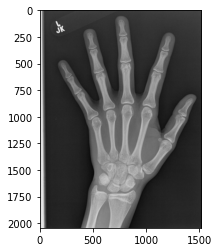

In [5]:
plt.imshow(cv2.imread(train_dirs[0] + '/1377.png'))

Mask an image as example

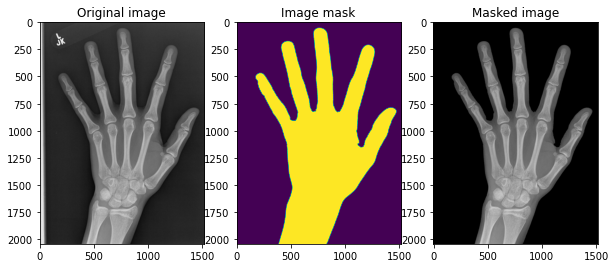

In [6]:
masks_path = 'boneage-training-dataset-masks'
image = cv2.imread(train_dirs[0] + '/1377.png')
mask = cv2.imread(path + '/' + masks_path + '/1377.png', 0)

fig, ax = plt.subplots(1,3, figsize=(10, 7))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(mask)
ax[1].set_title('Image mask')
ax[2].imshow(cv2.bitwise_and(image, image, mask=mask))
ax[2].set_title('Masked image')
plt.show()

## Creating dataframes

In [7]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/utils.py" utils.py
from utils import *

train_df = load_filenames('train.csv', train_dirs[0])
validation_df = load_filenames(data_dirs[1] + '/Validation Dataset.csv', val_dirs[0], val_dirs[1])
test_df = load_filenames(data_dirs[2] + '/Bone age ground truth.xlsx', data_dirs[2] + '/Test Set Images')

# normalize boneage value to accelerate training
mean_bone_age = train_df['boneage'].mean()
std_bone_age = train_df['boneage'].std()
train_df['boneage_n'] = (train_df['boneage'] - mean_bone_age) / std_bone_age
validation_df['boneage_n'] = (validation_df['boneage'] - mean_bone_age) / std_bone_age
test_df['boneage_n'] = (test_df['boneage'] - mean_bone_age) / std_bone_age

# number of steps between epochs
train_steps = int(np.ceil(train_df.shape[0] / batch_size))
val_steps = int(np.ceil(validation_df.shape[0] / batch_size))

In [8]:
# display(train_df[:5])
# display(validation_df[:5])
# display(test_df[:5])

## Data augmentation, Batching, Normalization

In [9]:
datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen = gen_2inputs(datagen_train, train_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen = gen_2inputs(datagen_val, validation_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

In [10]:
# train_df['gender(M/F)'] = tf.convert_to_tensor(train_df['gender(M/F)'])
# train_df['boneage'] = tf.convert_to_tensor(train_df['boneage'])
# train_df['boneage_n'] = tf.convert_to_tensor(train_df['boneage_n'])

In [11]:
# train_df.columns = ['input_1', 'input_2', 'boneage', 'boneage_n']

In [12]:
# generator = datagen_train.flow_from_dataframe(dataframe=train_df,
#         x_col='image', y_col='boneage_n', batch_size=batch_size, seed=1, shuffle=True, class_mode='other',
#         target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale', drop_duplicates=False)

# dataset = tf.data.Dataset.from_generator(lambda: train_gen, output_types=({"input_1": tf.float32, "input_2": tf.float32}, tf.float32), 
#                                          output_shapes=({"input_1":(32, 244, 244, 1), "input_2":(32, )}, (32,)))

In [13]:
# for element in dataset.as_numpy_iterator():
#   print(element)

## Models for prediction

In [43]:
!rm models.py

In [44]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/models.py" models.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/inc_v4.py" inc_v4.py
# !cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/simple_conv.py" simple_conv.py
from models import *

We use the mean absolute error as metric, as suggested in the papers

In [45]:
def mae_in_months(x, y):
    """
    Return mean absolute error in months

    Arguments:
    x -- predicted value
    y -- ground-truth
    """
    mean_bone_age = train_df['boneage'].mean()
    std_bone_age = train_df['boneage'].std()
    return mean_absolute_error((std_bone_age*x + mean_bone_age), (std_bone_age*y + mean_bone_age)) 

In [46]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)
model_name = 'incV4'
incV4_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=True)

Create the callbacks for the fit function

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name) # change the name
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
    save_best_only=True, mode='min', save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', 
                                min_delta=0.0001, cooldown=0, min_lr=0)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [48]:
incV4_history, incV4_time = fit_boneage(incV4_model, train_gen, train_steps, val_gen, val_steps,
                                        1, callbacks, path, gender=True)

395/395 [==============================] - ETA: 0s - loss: 0.8217 - mae_in_months: 33.8395
Epoch 1: val_loss improved from 0.78210 to 0.77835, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV4_weights.best.hdf5
395/395 [==============================] - 1024s 3s/step - loss: 0.8217 - mae_in_months: 33.8395 - val_loss: 0.7783 - val_mae_in_months: 32.0538 - lr: 0.0010


ValueError: ignored

In [ ]:
print(incV4_history.history.keys())

NameError: ignored

### InceptionV4
In this case we took the First-place replacing the Inception V3 model with an Inception V4, with the result of concatenating the 32-dimension vector corresponding to the gender with the pixels' vector of 75,264 dimensions (instead of 100,352)

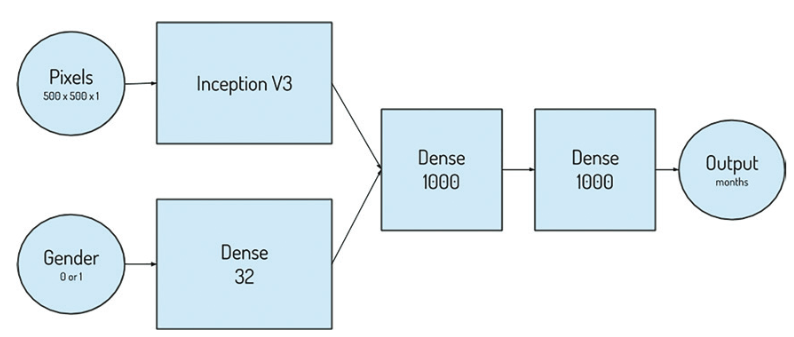

In [ ]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/inc_v4.py" inc_v4.py
from inc_v4 import *

incV4_model = Bone_Age_incV4((IMG_SIZE, IMG_SIZE, 1), with_gender=True)
incV4_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[mae_in_months])

### Simple CNN
Here we used a simple multi-layer convolution network 


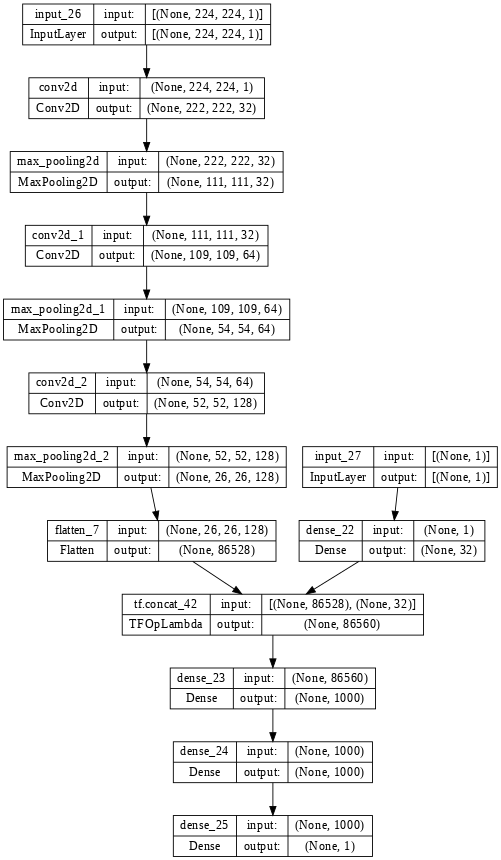

In [ ]:
# !cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/simple_conv.py" simple_conv.py
from simple_conv import *

conv_model = Simple_Conv((IMG_SIZE, IMG_SIZE, 1))
conv_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[mae_in_months])
tf.keras.utils.plot_model(conv_model, show_shapes=True, dpi=64)

### VGG16

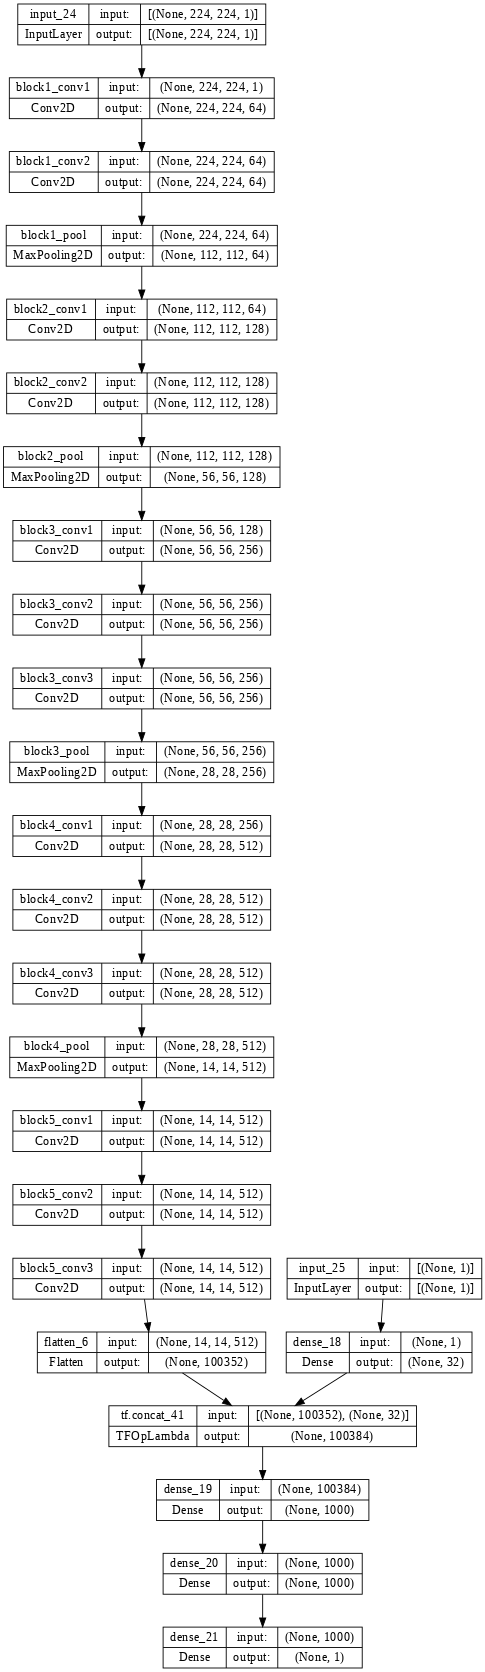

In [ ]:
from keras.applications.vgg16 import VGG16

def VGG16_boneage(input_shape, with_gender=True):
  X_input = Input(shape=input_shape)
  gen_input = Input(shape=(1,))

  # vgg16_model = VGG16(input_shape=input_shape, include_top=False, weights=None)
  # vgg16_model.trainable = True
  # vgg16_out = vgg16_model(X_input)

  vgg16_model = VGG16(input_tensor=X_input, include_top=False, weights=None)
  vgg16_model.trainable = True
  vgg16_out = vgg16_model.get_layer('block5_conv3').output

  # X = AveragePooling2D((2, 2))(vgg16_out)
  X = Flatten()(vgg16_out)

  if with_gender:
    # Dense block (gender)
    gen = Dense(32, activation='relu')(gen_input)

    # Concatenation
    # X = tf.concat(values=[X, gen], axis=3)
    X = tf.concat(values=[X, gen], axis=1)

  # First Dense block
  X = Dense(1000, activation='relu')(X)

  # Second Dense block
  X = Dense(1000, activation='relu')(X)

  # Fully connected layer
  X = Dense(1)(X)

  return tf.keras.Model(inputs=[X_input, gen_input], outputs=X, name='vgg16_boneage')

vgg16_model = vgg16_boneage((IMG_SIZE, IMG_SIZE, 1))
vgg16_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[mae_in_months])
tf.keras.utils.plot_model(vgg16_model, show_shapes=True, dpi=64)

## Model comparison

In [ ]:
start_time = time.time()
incV4_model_history = incV4_model.fit(train_gen, steps_per_epoch=train_steps, validation_data=val_gen, 
                      validation_steps=val_steps, epochs=1, callbacks=[checkpoint, early_stopping, reduce_lr])
incV4_time = time.time() - start_time
print('Training time: ' + str(incV4_time))

Found 12611 validated image filenames.
Found 12611 validated image filenames.
395/395 [==============================] - ETA: 0s - loss: 0.8330 - mae_in_months: 34.3030Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 0.78250, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpointsincv4_weights.best.hdf5
395/395 [==============================] - 1047s 3s/step - loss: 0.8330 - mae_in_months: 34.3030 - val_loss: 0.7825 - val_mae_in_months: 32.2247 - lr: 0.0010
Training time: 1059.4981651306152


In [ ]:
# model.save(path + 'Unet-LR={}_epochs={}_trainable={}_contrast.h5'.format(LR, EPOCHS, trainable)) 
incV4_model.save(path + 'models/' + 'InceptionV4-gender={}_epochs={1}.h5'.format(True, 1))

In [ ]:
model = tf.keras.models.load_model(path + 'models/' + 'InceptionV4-gender={}_epochs={1}.h5'.format(True, 1), compile=False)

In [ ]:
plot_loss(incV4_model_history)
plt.savefig(path + 'plots/incV4_train_loss.png')

In [ ]:
plot_accuracy(incV4_model_history)

In [ ]:
start_time = time.time()
conv_model_history = conv_model.fit(train_gen, steps_per_epoch=train_steps, validation_data=val_gen, 
                      validation_steps=val_steps, epochs=1, callbacks=[early_stopping, reduce_lr])
conv_time = time.time() - start_time
print('Training time: ' + str(conv_time))

Training time: 901.8353638648987


In [ ]:
start_time = datetime.time()
vgg16_history = vgg16_model.fit(train_gen_nogender, steps_per_epoch=train_steps, validation_data=val_gen_nogender, 
                      validation_steps=val_steps, epochs=1, callbacks=[early_stopping, reduce_lr])
vgg16_time = datetime.time() - start_time
print('Training time: ' + vgg16_time)

In [ ]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/models.py" models.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/inc_v4.py" inc_v4.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/simple_conv.py" simple_conv.py
from models import *

model = create_model('inceptionV4', (IMG_SIZE, IMG_SIZE, 1), mae_in_months)
model.load_weights(weight_path)

# Evaluate the model
loss, acc = model.evaluate(test_gen, verbose=2)
print("model accuracy: {:5.2f}%".format(100 * acc))

Found 200 validated image filenames.
Found 200 validated image filenames.


In [ ]:
# test_gen.reset()
y_pred = incV4_model.predict(test_gen, steps=test_df.shape[0])
predict = y_pred.flatten()
predicted_months = mean_bone_age + std_bone_age*(predict)
print("months predicted: {}, real boneage {}".format(str(predicted_months[i]),
      str(test_df.loc[i, 'boneage'])) for i in range(len(predicted_months)))

## Gender assesment

In [ ]:
incV4_nogender = Bone_Age_incV4((IMG_SIZE, IMG_SIZE, 1), with_gender=False)
incV4_nogender.compile(loss='mean_absolute_error', optimizer='adam', metrics=[mae_in_months])

start_time = time.time()
incV4_nogender_history = incV4_nogender.fit(train_gen, steps_per_epoch=train_steps, validation_data=val_gen, 
                      validation_steps=val_steps, epochs=1, callbacks=[early_stopping, reduce_lr])
incV4_nogender_time = time.time() - start_time
print('Training time: ' + str(incV4_nogender_time))

Found 12611 validated image filenames.
Found 12611 validated image filenames.
395/395 [==============================] - ETA: 0s - loss: 0.8711 - mae_in_months: 35.8739Found 1425 validated image filenames.
Found 1425 validated image filenames.
395/395 [==============================] - 1004s 2s/step - loss: 0.8711 - mae_in_months: 35.8739 - val_loss: 0.8359 - val_mae_in_months: 34.4252 - lr: 0.0010
Training time: 1058.6890699863434


In [ ]:
plot_loss(incV4_nogender_history)
plt.savefig(path + 'plots/incV4_nogender_train_loss.png')

## Attention Guided CNN (AG-CNN)
[Guan2018] https://github.com/Ien001/AG-CNN


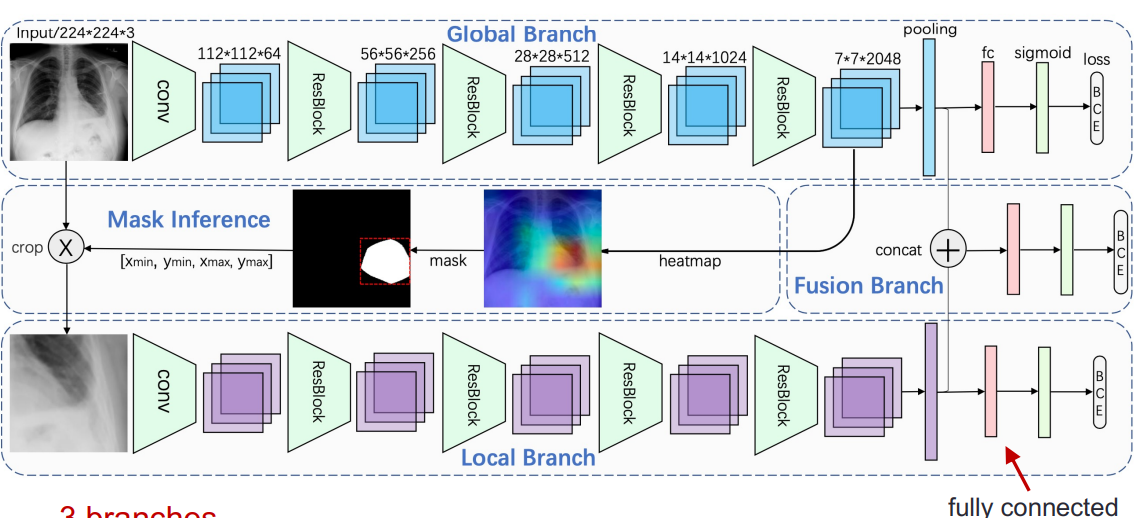

In [ ]:
#@title
# def Fusion_Branch(img_shape_global, img_shape_local):

#     Global_input = Input(shape=img_shape_global)
#     Local_input = Input(shape=img_shape_local)

#     # Concatenation of image and gender data
#     X = tf.concat(values=[Global_input, Local_input], axis=1) # should I resize

#     X = Dense(1)(X)
#     X = Sigmoid()(X)

#     return tf.keras.Model(inputs=[X_input, gen_input], outputs=X, name='Fusion_Branch')

In [ ]:
#@title
# def Attention_gen_patchs(ori_image, features):
#     # feature map -> feature mask (using feature map to crop on the original image) -> crop -> patchs
#     # feature_conv = fm_cuda.data.cpu().numpy()
#     size_upsample = (224, 224) 
#     bz, nc, h, w = features.shape

#     # patchs_cuda = torch.FloatTensor().cuda()

#     for i in range(0, bz):
#         feature = features[i]
#         cam = feature.reshape((nc, h*w))
#         cam = cam.sum(axis=0)
#         cam = cam.reshape(h,w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         cam_img = np.uint8(255 * cam_img)

#         heatmap_bin = binImage(cv2.resize(cam_img, size_upsample))
#         heatmap_maxconn = selectMaxConnect(heatmap_bin)
#         heatmap_mask = heatmap_bin * heatmap_maxconn

#         ind = np.argwhere(heatmap_mask != 0)
#         minh = min(ind[:,0])
#         minw = min(ind[:,1])
#         maxh = max(ind[:,0])
#         maxw = max(ind[:,1])
        
#         # to ori image 
#         image = ori_image[i].numpy().reshape(224,224,3)
#         # image = ori_image[i].numpy().reshape(224,224,1)
#         image = image[int(224*0.334):int(224*0.667),int(224*0.334):int(224*0.667),:]

#         image = cv2.resize(image, size_upsample)
#         image_crop = image[minh:maxh,minw:maxw,:] * 256 # because image was normalized before
#         image_crop = preprocess(Image.fromarray(image_crop.astype('uint8')).convert('RGB')) 

#         img_variable = torch.autograd.Variable(image_crop.reshape(3,224,224).unsqueeze(0).cuda())

#         patchs_cuda = torch.cat((patchs_cuda,img_variable),0)

#     return patchs_cuda

In [ ]:
#@title
# def Attention_gen_patchs(features, pt_depth):
#   X = Conv2D(64, kernel_size=(1, 1), padding='same', activation='relu')(features)
#   X = Conv2D(16, kernel_size=(1, 1), padding='same', activation='relu')(X)
#   X = LocallyConnected2D(1, kernel_size=(1, 1), padding='valid', activation='sigmoid')(X)
  
#   # pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
#   # fan it out to all of the channels
#   up_c2_w = np.ones((1, 1, 1, pt_depth))
#   up_c2 = Conv2D(pt_depth, kernel_size=(1, 1), padding='same',
#                 activation='linear', use_bias=False, weights=[up_c2_w])
#   up_c2.trainable = False
#   X = up_c2(X)

In [ ]:
#@title
# input_shape_global = (IMG_SIZE, IMG_SIZE, 1)
# input_shape_local = (IMG_SIZE, IMG_SIZE, 1)

# Global_Branch_model = Bone_Age_incV4(input_shape_global)
# Local_Branch_model = Bone_Age_incV4(input_shape_local)
# Fusion_Branch_model = Fusion_Branch(input_shape_global, input_shape_local)

# Global_Branch_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[mae_in_months])
# Local_Branch_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[mae_in_months])
# Fusion_Branch_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[mae_in_months])

In [ ]:
#@title
# start_time = datetime.time()
# global_branch_history = Global_Branch_model.fit(train_gen, steps_per_epoch=train_steps, validation_data=val_gen, 
#                       validation_steps=val_steps, epochs=1, callbacks=[early_stopping, reduce_lr])
# global_branch_time = datetime.time() - start_time
# print('Training time Global Branch: ' + global_branch_time)

# features_global = Global_Branch_model.get_layer('before pooling').output # change name
# pt_depth = Global_Branch_model.get_output_shape_at(0)[-1]
# patchs_var = Attention_gen_patchs(features_global, pt_depth)

# local_branch_history = Local_Branch_model.fit(train_gen_nogender, steps_per_epoch=train_steps, validation_data=val_gen_nogender, 
#                       validation_steps=val_steps, epochs=1, callbacks=[early_stopping, reduce_lr])
# local_branch_time = datetime.time() - global_branch_time
# print('Training time Local Branch: ' + local_branch_time)

# global_branch_pooling = Global_Branch_model.get_layer('pooling').output # change name
# local_branch_pooling = Local_Branch_model.get_layer('pooling').output # change name
# fusion_branch_history = Fusion_Branch_model.fit([global_branch_pooling, local_branch_pooling], train_df['boneage_z'], 
#                                                 steps_per_epoch=train_steps, epochs=1, callbacks=[early_stopping, reduce_lr])
# fusion_branch_time = datetime.time() - local_branch_time
# print('Training time Fusion Branch: ' + fusion_branch_time)

In [ ]:
#@title
# for epoch in range(num_epochs):
#   start_time = time.time()
#   print('Epoch {}/{}'.format(epoch , num_epochs - 1))
#   print('-' * 10)
#   #Iterate over data
#   for i, (input, target) in enumerate(train_loader):

  
# fusion_time = time.time() - start_time